# 2-Layer Neural Network | Text Colour Predictor

Task:
- Feed-forward neural network.
- Feed RGB values of 'background colour'.
- Predict if dark or light coloured text should be used over the RGB colour to make the text readable.

## Import libraries:

In [1]:
# Import libraries:
import numpy as np # For linear algebra.
import pandas as pd # For data processing, CSV file I/O (e.g. pd.read_csv).
import matplotlib.pyplot as plt # For data visualisation.
from PIL import Image, ImageDraw, ImageFont, ImageEnhance
%matplotlib inline

## RGB class and tool functions:

In [2]:
class Error(Exception):
    """Base class for exceptions in this module."""
    pass

class InputError(Error):
    '''Exception raised for errors in the input.

    Attributes:
        expr -- Input expression in which the error occurred.
        msg  -- Explanation of the error.'''
    def __init__(self, expr, msg):
        self.expr = expr
        self.msg = msg

class RGB():
    '''Defined with values for RGB as input.
    
    Attributes:
        RGB -- Input RGB values should range from 0 to 255.
        hex -- Automatically converts RGB to hex values.'''
    def __init__(self, R, G, B):
        for X in [R, G, B]:
            if (X < 0) or (X > 255):
                raise InputError(X, 'Not an RGB value.')
        self.R = R
        self.G = G
        self.B = B
        self.RGB = (R, G, B)
        self.hex = '#{:02X}{:02X}{:02X}'.format(self.R,self.G,self.B)

def generate_RGB_data(X, extreme=False):
    '''Generates a list filled with X number of RGB class values.
    Optional: generate cols that are v. dark + v. light for training.
    
    Attributes:
        X -- Number of desired RGB instances.
        extreme -- Boolean to generate v. dark + v. light cols.'''
    if extreme == True:
        cols = []
        for x in range(X):
            minimum = 127*(x%2)
            maximum = 255-(127*(not x%2))
            rgb = RGB(np.random.randint(low=minimum, high=maximum),
                      np.random.randint(low=minimum, high=maximum),
                      np.random.randint(low=minimum, high=maximum))
            cols.append(rgb)
        return cols
                        
    else:
        return [RGB(np.random.randint(0, 255),
                    np.random.randint(0, 255),
                    np.random.randint(0, 255))
                for i in range(X)]

def display_RGB_colour(colour, font_col='#000'):
    '''Will draw a box of given colour;
    and fill with text of given font colour.
    
    Attributes:
        colour -- String containing a RGB or hex value.
        font_col -- String containing a RGB or hex value.'''
    img = Image.new(mode='RGB', size=(100, 100), color=colour)
    img_draw = ImageDraw.Draw(img)
    img_draw.text((36, 45), 'Text', fill=font_col)
    plt.imshow(img)
    plt.show();

## Data visualisation:

RGB: (116, 104, 99) Hex: #746863


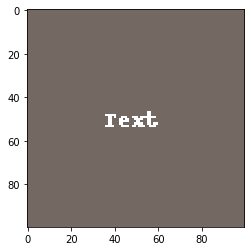

RGB: (131, 227, 153) Hex: #83E399


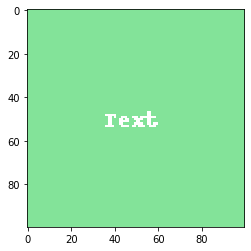

In [3]:
# Test the RGB class and data visualisation tool functions:
colours = generate_RGB_data(X=2, extreme=True)

for colour in colours:
    print('RGB:', colour.RGB, 'Hex:', colour.hex)
    display_RGB_colour(colour=colour.RGB, font_col='#fff')

## Generate data:

In [4]:
np.random.seed(2) # Optional: set seed for data generation.

data = pd.DataFrame([x.RGB for x in generate_RGB_data(X=200, extreme=1)],
                     columns=['R', 'G', 'B'])
display('Training set:', data)

'Training set:'

,R,G,B
0,40,15,109
1,199,149,170
2,82,75,104
3,134,161,176
4,95,75,85
...,...,...,...
195,201,205,240
196,127,104,14
197,196,240,143
198,126,91,5


## Assign Labels (NB: lazy method)

In [5]:
# Import libraries:
from sklearn.cluster import AgglomerativeClustering

In [6]:
clusterer = AgglomerativeClustering(n_clusters=2, linkage='ward').fit(data.values)
y = clusterer.labels_
print(y)

[0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0
 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1
 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0
 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1
 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0
 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1]


---> light text


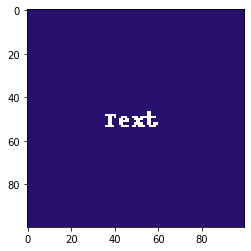

---> dark text


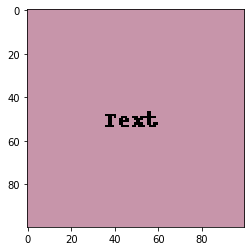

In [7]:
for i, label in enumerate(y[:2]):
    
    if label == 0: # NB: must check for most appriate label-to-class assignment.
        print('---> light text')
        display_RGB_colour(colour=tuple(data.iloc[i, :]), font_col='#fff')
        
    else:
        print('---> dark text')
        display_RGB_colour(colour=tuple(data.iloc[i, :]), font_col='#000')

## Train/test split:

In [8]:
# Import libraries:
from sklearn.model_selection import train_test_split

In [9]:
# Split data into training & testing sets:
train, test = train_test_split(data.join(pd.Series(y, name='y')))

display(train.head())
display(test.head())

,R,G,B,y
142,59,97,99,0
34,56,82,1,0
198,126,91,5,0
16,80,52,110,0
19,176,166,254,1


,R,G,B,y
163,144,167,206,1
59,218,237,223,1
63,221,237,222,1
176,28,80,111,0
87,178,242,154,1


## Building the NN:

In [10]:
# Define Neuron class:
class NeuralNetwork():
    def __init__(self, X, y, bias=1, eta=0.1, w1=None, w2=None, num_nodes=2, num_hidden=2, linear=False):
        self.X = X
        self.y = y
        self.eta = eta
        self.w1 = np.random.rand(num_nodes, self.X.shape[0]) if w1 is None else w1
        self.w2 = np.random.rand(self.y.shape[0], num_nodes) if w2 is None else w2
        self.b1 = np.ones((self.w1.shape[0], self.X.shape[1]), dtype=float)*bias
        self.b2 = np.ones(self.y.shape, dtype=float)*bias
        self.output = np.zeros(self.y.shape)
        self.linear = linear
    
    def activ_func(self, x):
        if self.linear is True: # For linear:
            return x
        else: # For sigmoid:
            return 1.0/(1.0 + np.exp(-x))
    
    def forwardpass(self):
        self.layer1 = self.activ_func(np.dot(self.w1, self.X) + self.b1)
        self.output = self.activ_func(np.dot(self.w2, self.layer1) + self.b2)
        
    def activ_deriv(self, x):
        if self.linear is True: # For linear:
            return 1
        else: # For sigmoid:
            return self.activ_func(x)*(1-self.activ_func(x))
    
    def error_deriv(self):
        return -(self.y-self.output)
    
    def backprop(self):
        '''Apply chain rule to find derivative of loss function.'''
        # Output layer:
        big_delta = self.error_deriv() * self.activ_deriv(x=np.dot(self.w2, self.layer1))
        output_unit = -self.eta * np.dot(big_delta, self.layer1.T)

        # Hidden layer:
        sml_delta = np.dot(big_delta.T, self.w2).T * self.activ_deriv(x=np.dot(self.w1, self.X))        
        hidden_unit = -self.eta * np.dot(sml_delta, self.X.T)
        
        '''Update the weights and biases with the derivative (slope) of the loss function.'''
        # Weights:
        self.w2 += output_unit
        self.w1 += hidden_unit
        
        # Biases:
        self.b2 += -self.eta * big_delta * self.b2
        self.b1 += -self.eta * sml_delta * self.b1
    
    def fit(self, Xs, ys, iterations=20):
        y_preds = []
        for i, X in enumerate(Xs): # Per data point:
            self.X = X
            self.y = ys[i]
            
            for i in range(iterations): # Per iteration:
                self.forwardpass()
                self.backprop()
                
            y_preds.append(self.output)
            
        return np.array(y_preds)
    
    def predict(self, Xs):
        y_preds = []
        for X in Xs:
            self.X = X
            self.forwardpass()
            
            y_preds.append(self.output)
            
        return np.array(y_preds)
    
    def display_test_results(self, Xs, y_preds):
        for i, y in enumerate(y_preds):
            if y == 0:
                print(y, '---> light text')
                display_RGB_colour(colour=tuple(Xs[i, :]), font_col='#fff')

            else:
                print(y, '---> dark text')
                display_RGB_colour(colour=tuple(Xs[i, :]), font_col='#000')

## Use the NN on dummy example:

In [11]:
# Setup inputs:
X = np.array([0, 1]).reshape((2,1))
y = np.array([1, 0]).reshape((2,1))
w1 = np.array([[-1, 0],
               [0, 1]], dtype=float)
w2 = np.array([[1, 0],
               [-1, 1]], dtype=float)

# Initialise NN:
NN = NeuralNetwork(X=X,
                   y=y,
                   bias=1,
                   eta=0.1,
                   w1=w1,
                   w2=w2,
                   num_nodes=2,
                   linear=True)

# Use NN:
NN.forwardpass()
print('\nForward Pass:\noutput:\n{}'.format(NN.output))

NN.backprop()
print('\nBackpropagation:\nhidden:\n{}\noutput:\n{}'.format(NN.w1, NN.w2))

NN.forwardpass()
print('\nForward Pass:\noutput:\n{}'.format(NN.output))


Forward Pass:
output:
[[2.]
 [2.]]

Backpropagation:
hidden:
[[-1.   0.1]
 [ 0.   0.8]]
output:
[[ 0.9 -0.2]
 [-1.2  0.6]]

Forward Pass:
output:
[[1.66]
 [0.32]]


## Train the NN on training set:

In [12]:
# Setup inputs:
input_X = train.values[0, :3].reshape((3,1))
input_y = train.values[0, 3].reshape((1,1))
print('X:\n{}\ny:\n{}'.format(input_X, input_y))

# Initialise NN:
NN = NeuralNetwork(X=input_X,
                   y=input_y,
                   bias=1,
                   eta=0.75,
                   w1=None,
                   w2=None,
                   num_nodes=10,
                   linear=False)

# Use NN:
NN.forwardpass()
print('\nForward Pass:\noutput:\n{}'.format(NN.output))

NN.backprop()
print('\nBackpropagation:\nhidden:\n{}\noutput:\n{}'.format(NN.w1, NN.w2))

NN.forwardpass()
print('\nForward Pass:\noutput:\n{}'.format(NN.output))

X:
[[59]
 [97]
 [99]]
y:
[[0]]

Forward Pass:
output:
[[0.99148359]]

Backpropagation:
hidden:
[[0.52474595 0.06149922 0.802029  ]
 [0.15658505 0.9401623  0.52745853]
 [0.6025448  0.65560032 0.45756057]
 [0.69052728 0.41612776 0.82280157]
 [0.95418826 0.36002632 0.03708779]
 [0.64598053 0.37466016 0.10058649]
 [0.30550836 0.28938723 0.80796671]
 [0.24348678 0.05105341 0.37871315]
 [0.92934918 0.0239447  0.0129707 ]
 [0.12498716 0.29316263 0.71664844]]
output:
[[0.42194578 0.11692613 0.01192931 0.49295524 0.2342046  0.81304991
  0.30072133 0.94628577 0.00845935 0.24493694]]

Forward Pass:
output:
[[0.98979717]]


In [13]:
# Setup inputs:
tr_i = train.shape[0]
train_Xs = train.values[:, :3].reshape((tr_i, 3, 1))
train_ys = train.values[:, 3].reshape((tr_i, 1))
print('Shapes of inputs:', train_Xs.shape, train_ys.shape)

# Train NN:
train_y_preds = NN.fit(Xs=train_Xs, ys=train_ys, iterations=20)
print('Shape of y_preds:', train_y_preds.shape)

Shapes of inputs: (150, 3, 1) (150, 1)
Shape of y_preds: (150, 1, 1)


In [14]:
train_y_preds

array([[[0.10008778]],

       [[0.05993819]],

       [[0.04648535]],

       [[0.03921082]],

       [[0.93918223]],

       [[0.96665677]],

       [[0.97486685]],

       [[0.9791295 ]],

       [[0.08940074]],

       [[0.0570345 ]],

       [[0.04494395]],

       [[0.94120477]],

       [[0.08248751]],

       [[0.94711698]],

       [[0.96782592]],

       [[0.08523487]],

       [[0.9468929 ]],

       [[0.08213164]],

       [[0.0543533 ]],

       [[0.94258652]],

       [[0.08142228]],

       [[0.05396202]],

       [[0.0429905 ]],

       [[0.93910995]],

       [[0.9652255 ]],

       [[0.08374097]],

       [[0.05446299]],

       [[0.94182548]],

       [[0.08064609]],

       [[0.94482702]],

       [[0.96606069]],

       [[0.0833052 ]],

       [[0.94463477]],

       [[0.08020239]],

       [[0.94399289]],

       [[0.96541224]],

       [[0.08264517]],

       [[0.94379815]],

       [[0.9651495 ]],

       [[0.97287587]],

       [[0.08449084]],

       [[0.94354

In [15]:
# Training results:
train_results = pd.DataFrame({'y_true': train.y.values,
                              'y_pred': np.round(train_y_preds).reshape((tr_i,)).astype(int),
                              'same': train.y.values == np.round(train_y_preds).reshape((tr_i,)).astype(int)})

display(train_results.head())

print('{}% error'.format(round(len(train_results[train_results.same==False]) / len(train_results) * 100)))

,y_true,y_pred,same
0,0,0,True
1,0,0,True
2,0,0,True
3,0,0,True
4,1,1,True


0% error


In [16]:
# Setup inputs:
te_i = test.shape[0]
test_Xs = test.values[:, :3].reshape((te_i, 3, 1))
test_ys = test.values[:, 3].reshape((te_i, 1))
print('Shapes of inputs:', test_Xs.shape, test_ys.shape)

# Test NN:
test_y_preds = NN.predict(Xs=test_Xs)
print('Shape of y_preds:', test_y_preds.shape)

Shapes of inputs: (50, 3, 1) (50, 1)
Shape of y_preds: (50, 1, 1)


In [17]:
# Testing results:
test_results = pd.DataFrame({'y_true': test.y.values,
                             'y_pred': np.round(test_y_preds).reshape((te_i,)).astype(int),
                             'same': test.y.values == np.round(test_y_preds).reshape((te_i,)).astype(int)})

display(test_results.head(15))

print('{}% error'.format(round(len(test_results[test_results.same==False]) / len(test_results) * 100)))

,y_true,y_pred,same
0,1,0,False
1,1,0,False
2,1,0,False
3,0,0,True
4,1,0,False
5,0,0,True
6,1,0,False
7,1,0,False
8,1,0,False
9,0,0,True


54% error


0 ---> light text


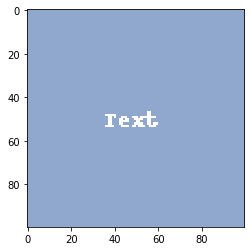

0 ---> light text


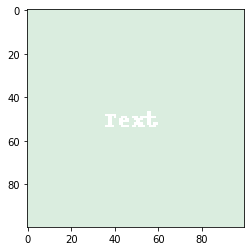

0 ---> light text


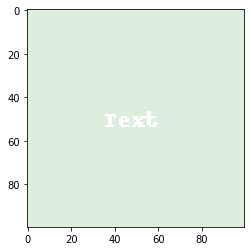

0 ---> light text


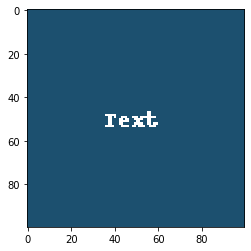

0 ---> light text


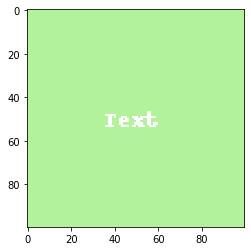

0 ---> light text


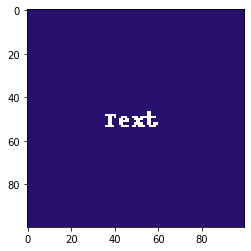

0 ---> light text


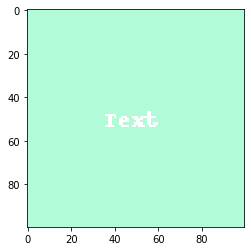

0 ---> light text


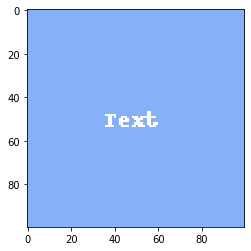

0 ---> light text


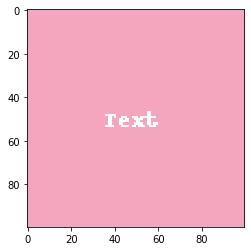

0 ---> light text


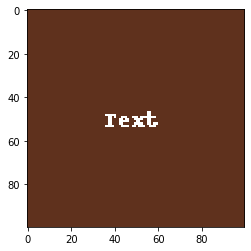

0 ---> light text


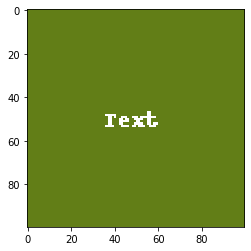

0 ---> light text


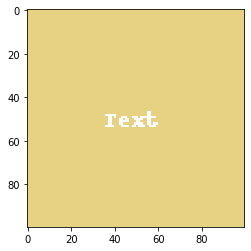

0 ---> light text


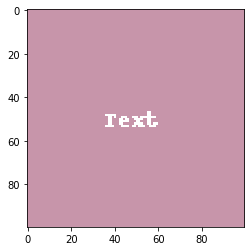

0 ---> light text


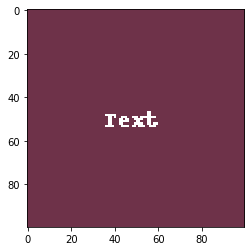

0 ---> light text


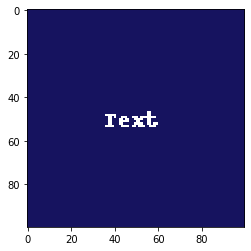

0 ---> light text


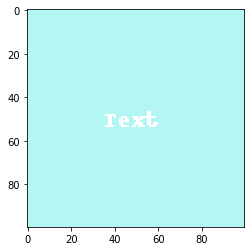

0 ---> light text


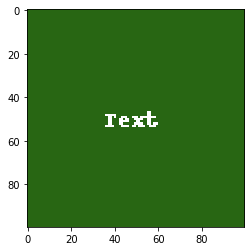

0 ---> light text


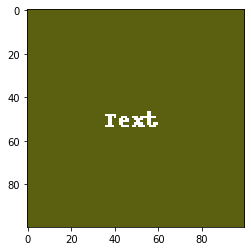

0 ---> light text


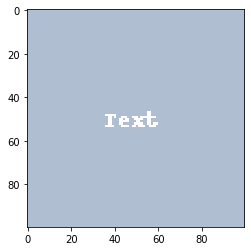

0 ---> light text


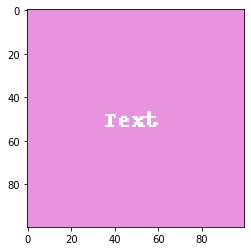

0 ---> light text


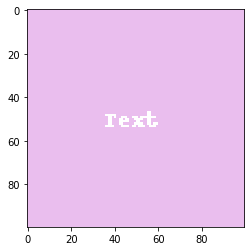

0 ---> light text


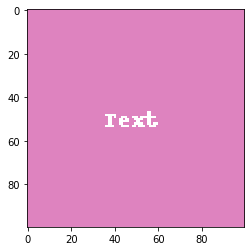

0 ---> light text


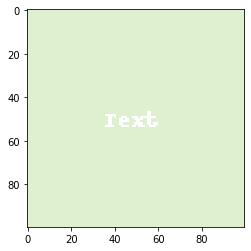

0 ---> light text


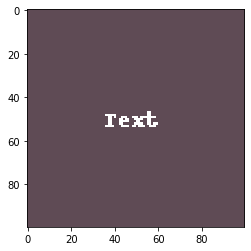

0 ---> light text


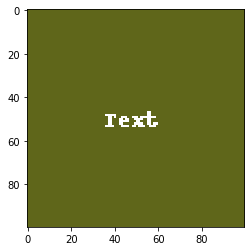

0 ---> light text


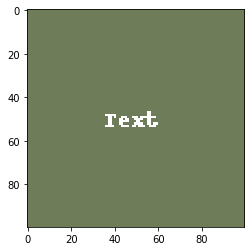

0 ---> light text


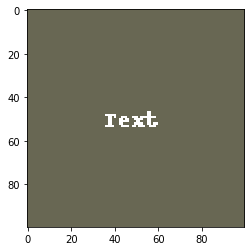

0 ---> light text


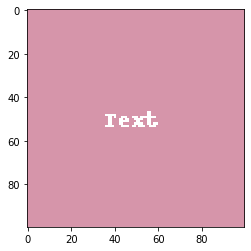

0 ---> light text


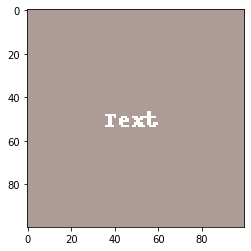

0 ---> light text


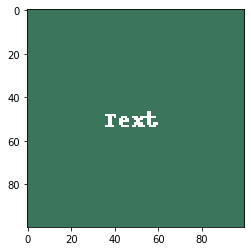

0 ---> light text


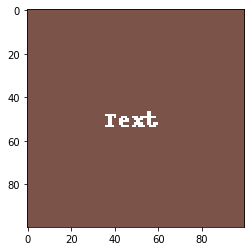

0 ---> light text


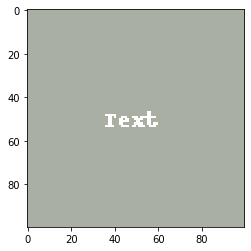

0 ---> light text


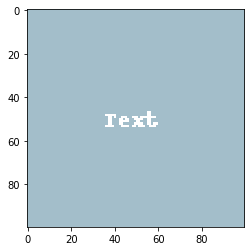

0 ---> light text


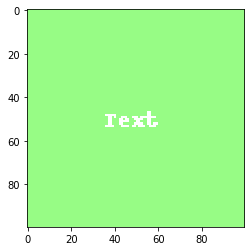

0 ---> light text


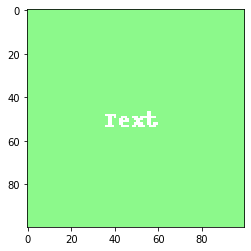

0 ---> light text


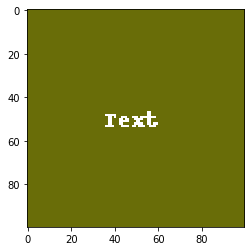

0 ---> light text


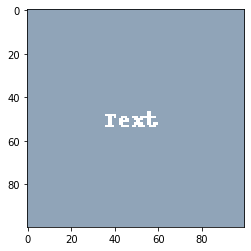

0 ---> light text


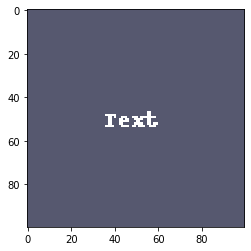

0 ---> light text


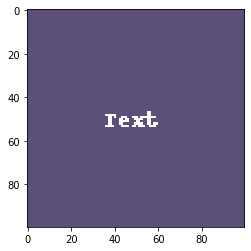

0 ---> light text


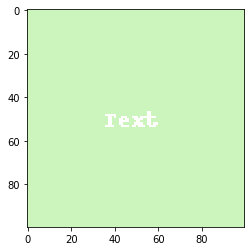

0 ---> light text


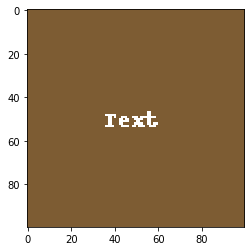

0 ---> light text


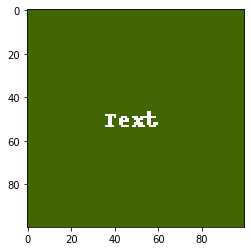

0 ---> light text


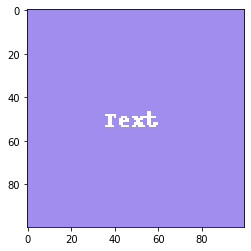

0 ---> light text


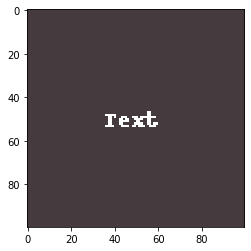

0 ---> light text


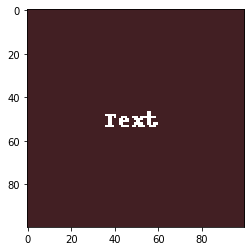

0 ---> light text


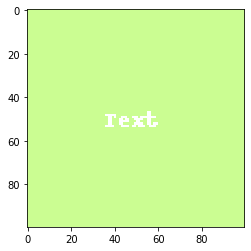

0 ---> light text


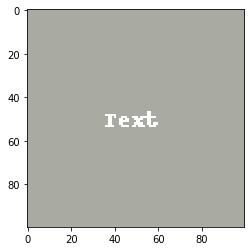

0 ---> light text


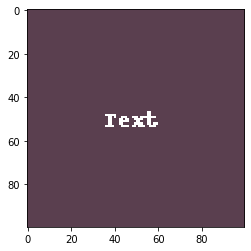

0 ---> light text


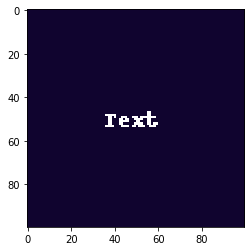

0 ---> light text


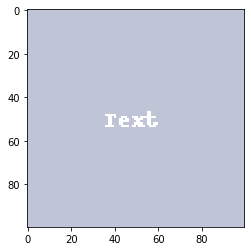

In [18]:
# Display results:
NN.display_test_results(Xs=test.values[:, :3],
                        y_preds=test_results.y_pred.values)

# NN via scikit-learn

In [19]:
from sklearn.neural_network import MLPClassifier

In [20]:
sklearn_NN = MLPClassifier(activation='logistic')

sklearn_NN

MLPClassifier(activation='logistic', alpha=0.0001, batch_size='auto',
              beta_1=0.9, beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(100,), learning_rate='constant',
              learning_rate_init=0.001, max_iter=200, momentum=0.9,
              n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
              random_state=None, shuffle=True, solver='adam', tol=0.0001,
              validation_fraction=0.1, verbose=False, warm_start=False)

In [21]:
sklearn_NN.fit(X=train.iloc[:, :3].values,
               y=train.y.values)

/opt/anaconda3/envs/myenv/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MLPClassifier(activation='logistic', alpha=0.0001, batch_size='auto',
              beta_1=0.9, beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(100,), learning_rate='constant',
              learning_rate_init=0.001, max_iter=200, momentum=0.9,
              n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
              random_state=None, shuffle=True, solver='adam', tol=0.0001,
              validation_fraction=0.1, verbose=False, warm_start=False)

In [22]:
sklearn_y_preds = sklearn_NN.predict(X=test.iloc[:, :3].values)

In [23]:
sklearn_results = pd.DataFrame({'y_true': test.y.values,
                                'y_pred': sklearn_y_preds,
                                'same': test.y.values == sklearn_y_preds})

display(sklearn_results.head())

print('{}% error'.format(round(len(sklearn_results[sklearn_results.same==False]) / len(sklearn_results) * 100)))

,y_true,y_pred,same
0,1,1,True
1,1,1,True
2,1,1,True
3,0,0,True
4,1,1,True


14% error


In [24]:
# The end.